# Chorus Example: Running Sei predictions


## Installation Instructions (Reference)

If you haven't installed Chorus yet, follow these steps:

```bash
# 1. Clone the repository
git clone https://github.com/pinellolab/chorus.git
cd chorus

# 2. Create the main Chorus environment
mamba env create -f environment.yml
mamba activate chorus

# 3. Install Chorus package
pip install -e .

# 4. Set up the Sei environment
chorus setup --oracle sei

# 5. Download the reference genome
chorus genome download hg38
```

**Note**: 
- For this notebook, we assume Chorus is already installed.
- pyGenomeTracks is now included in the environment for advanced visualization!

## Setup and Imports

In [25]:
# Import required libraries
import chorus
from chorus.utils import get_genome, extract_sequence, download_gencode
from chorus.utils.visualization import visualize_chorus_predictions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Set up matplotlib for inline display
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt

# Set up plotting with white background
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100  # Increase DPI for better quality

print("Chorus version:", chorus.__version__ if hasattr(chorus, '__version__') else "development")

Chorus version: 0.1.0


## 1. Setting up Reference Genome and Sei Oracle

In [26]:
# Download gene annotations
print("\nSetting up gene annotations...")
gtf_path = download_gencode(version='v48', annotation_type='basic')
print(f"Using annotations: {gtf_path}")

INFO:chorus.utils.annotations:Annotation file already exists: /home/penzard/pinellolab/chorus/annotations/gencode.v48.basic.annotation.gtf.gz



Setting up gene annotations...
Using annotations: /home/penzard/pinellolab/chorus/annotations/gencode.v48.basic.annotation.gtf.gz


In [27]:
# Get reference genome (auto-downloads if not present)
print("Setting up reference genome...")
genome_path = get_genome('hg38')
print(f"Using genome: {genome_path}")

# Create Enformer oracle with environment isolation
print("\nCreating Sei oracle...")
# For different configurations:
# - Force CPU: device='cpu'
# - Use specific GPU: device='cuda:0'
oracle = chorus.create_oracle(
    'sei',
    sliding_predict=True,
    use_environment=True,
    reference_fasta=str(genome_path),
    device="cuda:1"
)

# Load pre-trained model
print("\nLoading pre-trained Sei model...")
print("To force CPU usage: device='cpu'")
print("To disable timeout: export CHORUS_NO_TIMEOUT=1")
oracle.load_pretrained_model(weights="/home/penzard/pinellolab/chorus/chorus/oracles/sei/")
print("Model loaded successfully!")

INFO:chorus.core.base:Device set to: cuda:1
INFO:chorus.core.environment.manager:Found conda via CONDA_EXE: /home/penzard/conda/bin/conda
INFO:chorus.core.environment.manager:Found mamba at: /home/penzard/conda/bin/mamba


Setting up reference genome...
Using genome: /home/penzard/pinellolab/chorus/genomes/hg38.fa

Creating Sei oracle...


INFO:chorus.core.base:Using conda environment: chorus-sei



Loading pre-trained Sei model...
Note: First-time loading downloads ~1GB model and may take 5-10 minutes
To force CPU usage: device='cpu'
To disable timeout: export CHORUS_NO_TIMEOUT=1


INFO:chorus.oracles.sei_oracle:Sei model loaded successfully in environment!


Model loaded successfully!


## 2. Exploring Available Tracks

In [28]:
# List available assay types
assay_types = oracle.list_assay_types()
print(f"Available assay types ({len(assay_types)}):")
for i, assay in enumerate(assay_types[:20], 1):
    print(f"  {i:2d}. {assay}")
print(f"  ... and {len(assay_types) - 20} more")
print("\n" + "="*50 + "\n")

# List available cell types (show first 20 due to large number)
cell_types = oracle.list_cell_types()
print(f"Available cell types ({len(cell_types)}):")
for i, cell in enumerate(cell_types[:20], 1):
    print(f"  {i:2d}. {cell}")
print(f"  ... and {len(cell_types) - 20} more")
print("\n" + "="*50 + "\n")

# List available class types (show first 20 )
class_types = oracle.list_class_types()
print(f"Available class types ({len(class_types)}):")
for i, cl in enumerate(class_types[:20], 1):
    print(f"  {i:2d}. {cl}")
print(f"  ... and {len(class_types) - 20} more")
print("\n" + "="*50 + "\n")

# List available group types (show first 20 )
group_types = oracle.list_group_types()
print(f"Available groups ({len(group_types)}):")
for i, group in enumerate(group_types, 1):
    print(f"  {i:2d}. {group}")


Available assay types (1176):
   1. BTAF1
   2. EOMES
   3. EP300
   4. FOXH1
   5. FOXP1
   6. H2BK12ac
   7. H2BK15ac
   8. H2BK5ac
   9. H3K18ac
  10. H3K23me2
  11. H3K27ac
  12. H3K27me3
  13. H3K36me3
  14. H3K4ac
  15. H3K4me1
  16. H3K4me2
  17. H3K4me3
  18. H3K56ac
  19. H3K79me2
  20. H3K9ac
  ... and 1156 more


Available cell types (1742):
   1. HeLa_Epithelium_Cervix
   2. H9_Embryonic_Stem_Cell_Embryo
   3. Endothelial_Cell_Artery
   4. LS174T_Epithelium_Colon
   5. HCT-116_Colon
   6. HEK293_Epithelium_Embryonic_Kidney
   7. HeLa-S3_Epithelium_Cervix
   8. HepG2_Epithelium_Liver
   9. hES_I3_Embryonic_Stem_Cell_Embryo
  10. Hs68_Fibroblast_Foreskin
  11. Satellite_Cells_Muscle
  12. HUES48_Embryonic_Stem_Cell_Embryo
  13. HUES6_Embryonic_Stem_Cell_Embryo
  14. HUES64_Embryonic_Stem_Cell_Embryo
  15. Endothelial_Cell_Umbilical_Vein
  16. IB4_Lymphocyte_Blood
  17. IMR90_Fibroblast_Lung
  18. iPS_4_iPSC
  19. iPS_A1_iPSC
  20. iPS_A6_iPSC
  ... and 1722 more


Available c

## Example: Select specific sequence classes or targets


In [29]:
classes = oracle.select_classes(pats=[[None, 'Promoter'],
                             [None, 'Enhancer']])

In [30]:
classes

['CA#E1@Stem cell@Enhancer@5',
 'CA#E2@Multi-tissue@Enhancer@6',
 'CA#E3@Brain / Melanocyte@Enhancer@7',
 'CA#E4@Multi-tissue@Enhancer@9',
 'CA#E5@B-cell-like@Enhancer@12',
 'CA#E6@Weak epithelial@Enhancer@13',
 'CA#E7@Monocyte / Macrophage@Enhancer@16',
 'CA#E8@Weak multi-tissue@Enhancer@17',
 'CA#P@Promoter@Promoter@25',
 'CA#E9@Liver / Intestine@Enhancer@26',
 'CA#E10@Brain@Enhancer@30',
 'CA#E11@T-cell@Enhancer@36',
 'CA#E12@Erythroblast-like@Enhancer@38']

In [31]:
targets = oracle.select_targets(pats=[['H3K4me1', 'HepG2'],
                             ['H3K4me1', 'K562']])

In [32]:
targets

['TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:2027',
 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35417',
 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35420',
 'TA#HepG2_Epithelium_Liver@H3K4me1@ID:36651',
 'TA#HepG2_Epithelium_Liver@H3K4me1@ID:45298',
 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:45407',
 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:45415',
 'TA#HepG2_Epithelium_Liver@H3K4me1@ID:51255',
 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:55733',
 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:55734',
 'TA#K562_human_erythroleukemic_cell_line@H3K4me1@ID:68375',
 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:8461',
 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:8462',
 'TA#HepG2_Hepatocellular_Carcinoma@H3K4me1@Roadmap',
 'TA#K562@H3K4me1@Roadmap']

## Example A: Wild-type Sequence Prediction


In [33]:
# Define GATA1 TSS region
gata1_region = "chrX:48777634-48790694"
print(f"Analyzing wild-type region: {gata1_region}")
print("This region contains the GATA1 transcription start site\n")

# Extract sequence information
wt_seq = extract_sequence(gata1_region, str(genome_path))
print(f"Region length: {len(wt_seq):,} bp")
print(f"GC content: {(wt_seq.count('G') + wt_seq.count('C')) / len(wt_seq) * 100:.1f}%")

Analyzing wild-type region: chrX:48777634-48790694
This region contains the GATA1 transcription start site

Region length: 13,061 bp
GC content: 47.2%


In [34]:
assay_ids = targets + classes
track_ids =  targets[0:2] + classes[0:2]

In [35]:
# Make predictions for wild-type sequence
print("Making predictions using specific track identifiers...")
print(f"Track IDs: {track_ids}")

wt_results = oracle.predict(
    ('chrX', 48777634, 48790694),
    track_ids  # Using specific track IDs
)

# Print statistics
for track_id, predictions in wt_results.items():
    print(f"\n{track_id}:")
    print(f"  Shape: {predictions.shape}")
    print(f"  Mean signal: {np.mean(predictions):.4f}")
    print(f"  Max signal: {np.max(predictions):.4f}")

Making predictions using specific track identifiers...
Track IDs: ['TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:2027', 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35417', 'CA#E1@Stem cell@Enhancer@5', 'CA#E2@Multi-tissue@Enhancer@6']

TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:2027:
  Shape: (4,)
  Mean signal: 0.0922
  Max signal: 0.3603

TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35417:
  Shape: (4,)
  Mean signal: 0.0168
  Max signal: 0.0625

CA#E1@Stem cell@Enhancer@5:
  Shape: (4,)
  Mean signal: 0.7717
  Max signal: 1.8352

CA#E2@Multi-tissue@Enhancer@6:
  Shape: (4,)
  Mean signal: 0.7344
  Max signal: 1.6828



Saving wild-type tracks...
Saved 4 files to bedgraph_outputs/

Creating visualization with gene annotations...


/home/penzard/pinellolab/chorus/chorus/utils/visualization.py:562: UserWarning: Error creating pyGenomeTracks plot: PlotTracks.__init__() got an unexpected keyword argument 'width'
  warnings.warn(f"Error creating pyGenomeTracks plot: {e}")


Saved visualization to: gata1_wt_with_genes.png


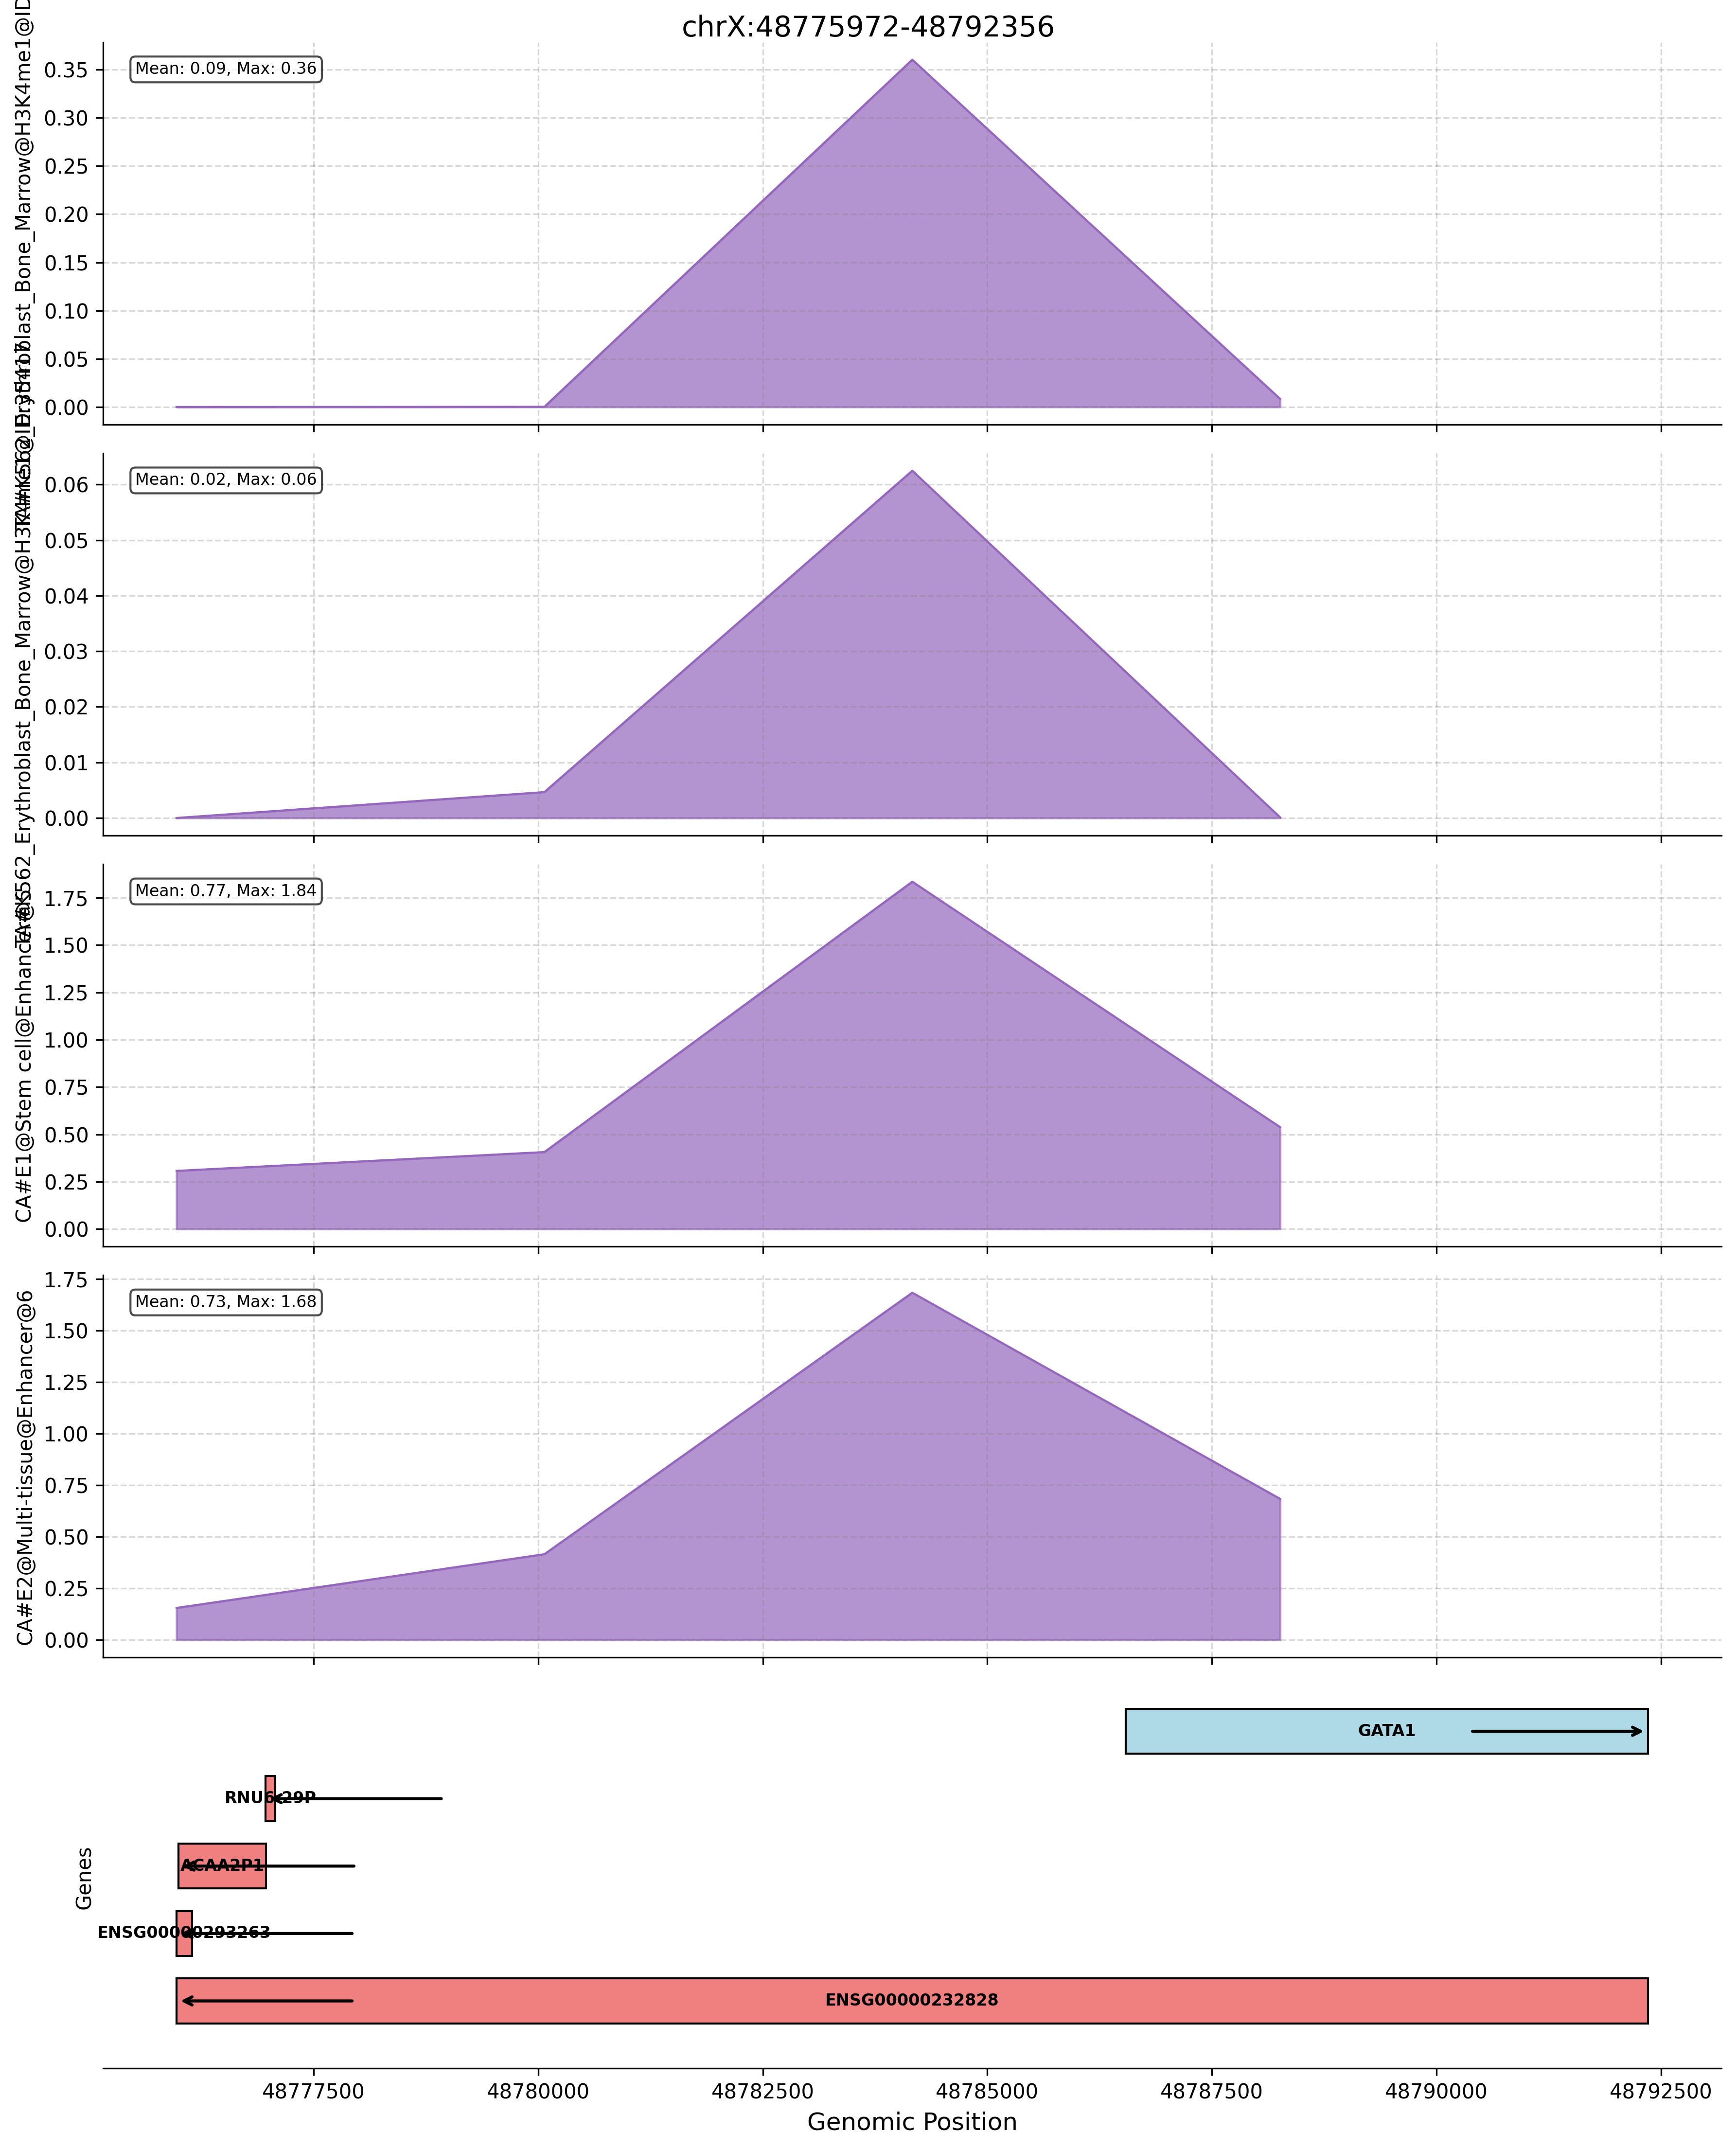

In [36]:
# Save tracks using oracle method - Enformer handles coordinate mapping internally
print("\nSaving wild-type tracks...")

wt_files = oracle.save_predictions_as_bedgraph(
    predictions=wt_results,
    chrom='chrX',
    start=wt_results.metainfo['positions'][0] ,
    output_dir="bedgraph_outputs",
    prefix='a_wt'
)
print(f"Saved {len(wt_files)} files to bedgraph_outputs/")

# Create visualization with gene annotations using pyGenomeTracks
print("\nCreating visualization with gene annotations...")
try:
    visualize_chorus_predictions(
        predictions=wt_results,
        chrom='chrX',
        start=wt_results.metainfo['positions'][0],  # Use output window start for visualization
        track_ids=track_ids,
        output_file='gata1_wt_with_genes.png',  # Save to file for pyGenomeTracks
        bin_size=oracle.bin_size,
        style='modern',
        gtf_file=str(gtf_path),  # Add gene annotations
        use_pygenometracks=True  # Use pyGenomeTracks for better gene visualization
    )
    print("Saved visualization to: gata1_wt_with_genes.png")
    
    # Display the saved image
    from IPython.display import Image, display
    display(Image('gata1_wt_with_genes.png', width=800))
    
except Exception as e:
    print(f"Could not create pyGenomeTracks visualization: {e}")
    print("Falling back to matplotlib visualization...")
    
    # Fallback to matplotlib for inline display
    visualize_chorus_predictions(
        predictions=wt_results,
        chrom='chrX',
        start=output_start,
        track_ids=track_ids,
        output_file=None,  # Display inline
        bin_size=oracle.bin_size,
        style='modern',
        gtf_file=str(gtf_path),
        use_pygenometracks=False
    )

## Example B: Region Replacement

Replace a sub-region with a synthetic sequence and analyze the effects.

In [38]:
# Define replacement parameters
replace_region = "chrX:48782929-48783129"
replacement_seq = "CTGCTTGCTTTAGCTTCAGGGTTCTTATCTTTTTTCATTTTATAACAGCAAAGGCGACACCCAACATGTGCGTGCTTGAGATAATGACTAAAAACTGCCCGTGACTCAAGCGCTTCTGGTGAGGGAAGATAAGGCAAGGAAACTGGCCGCCTAGATAGCCCTGGGAATGAGGCAGTCTCTGTTCTGGGTAAAGTGTCTGC"

print(f"Replacing region: {replace_region}")
print(f"Original region length: 200 bp")
print(f"Replacement sequence length: {len(replacement_seq)} bp")
print(f"\nReplacement sequence (first 50 bp): {replacement_seq[:50]}...")

Replacing region: chrX:48782929-48783129
Original region length: 200 bp
Replacement sequence length: 200 bp

Replacement sequence (first 50 bp): CTGCTTGCTTTAGCTTCAGGGTTCTTATCTTTTTTCATTTTATAACAGCA...


In [14]:
# Make predictions with replacement
print("Making predictions with replaced region...\n")
replacement_results = oracle.predict_region_replacement(
    genomic_region=replace_region,
    seq=replacement_seq,
    assay_ids=track_ids,  # Using specific track IDs
    create_tracks=False,
    genome=str(genome_path)
)

# Analyze changes
print("Signal changes due to replacement:")
for track_id in track_ids:
    predictions = replacement_results['raw_predictions'][track_id]
    print(f"\n{track_id}:")
    print(f"  Signal: {predictions[0]:.4f}")
   

Making predictions with replaced region...

Signal changes due to replacement:

TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:2027:
  Signal: 0.0231

TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35417:
  Signal: 0.0151

CA#E1@Stem cell@Enhancer@5:
  Signal: 5.3219

CA#E2@Multi-tissue@Enhancer@6:
  Signal: 5.5740


## Example C: Sequence Insertion

Insert the same sequence at a different position to see how location affects predictions.

In [40]:
# Define insertion parameters
insertion_pos = "chrX:48781929"
insert_seq = replacement_seq  # Use same sequence as before

print(f"Inserting at position: {insertion_pos}")
print(f"Insert sequence length: {len(insert_seq)} bp")
print("This insertion is ~1kb upstream of the replacement position")

Inserting at position: chrX:48781929
Insert sequence length: 200 bp
This insertion is ~1kb upstream of the replacement position


In [41]:
# Make predictions with insertion
print("\nMaking predictions with insertion...\n")
insertion_results = oracle.predict_region_insertion_at(
    genomic_position=insertion_pos,
    seq=insert_seq,
    assay_ids=track_ids,  # Using specific track IDs
    create_tracks=False,
    genome=str(genome_path)
)

# Analyze impact around insertion site
print("Impact of insertion:")
for track_id in track_ids:
    predictions = insertion_results['raw_predictions'][track_id]
    # Center of output is where insertion occurs
    center = len(predictions) // 2
    window = 20
    local_signal = predictions[center-window:center+window]
    
    print(f"\n{track_id}:")
    print(f"  Signal: {predictions[0]:.4f}")


Making predictions with insertion...

Impact of insertion:

TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:2027:
  Signal: 0.0079

TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35417:
  Signal: 0.0360

CA#E1@Stem cell@Enhancer@5:
  Signal: 3.1905

CA#E2@Multi-tissue@Enhancer@6:
  Signal: 2.6657


## Example D: Variant Effect Analysis

Test the effect of single nucleotide polymorphisms (SNPs) at a specific position.

In [42]:
# Define variant to test
variant_pos = 48786129
ref_seq = 'C'  # Corrected reference allele from 'G' to 'C'

print(f"Testing variant at chrX:{variant_pos}")
print(f"Reference allele: {ref_seq}")

# Create alleles list with reference first, then alternatives
alt_alleles = [a for a in ['A', 'C', 'G', 'T'] if a != ref_seq]
test_alleles = [ref_seq] + alt_alleles  # Reference first, then alternatives

print(f"Testing substitutions: {ref_seq} -> {', '.join(alt_alleles)}")

# Need a wider region for variant analysis
print("\nPredicting variant effects...\n")
variant_results = oracle.predict_variant_effect(
    genomic_region=f"chrX:{variant_pos-5000}-{variant_pos+5000}",
    variant_position=f"chrX:{variant_pos}",
    alleles=test_alleles,  # Reference first, then alternatives
    assay_ids=track_ids,  # Using specific track IDs
    genome=str(genome_path)
)

print("\nVariant predictions completed!")

Testing variant at chrX:48786129
Reference allele: C
Testing substitutions: C -> A, G, T

Predicting variant effects...


Variant predictions completed!


In [43]:
from chorus.oracles.sei.annotations import SeiTarget, SeiClass

In [44]:
# Analyze variant effects
print("Variant effect analysis:")
print("=" * 60)

# Create results dataframe
variant_effects = []

# Check the structure first
print(f"\nVariant results keys: {variant_results.keys()}")
print(f"Predictions keys: {variant_results['predictions'].keys()}")

# Get reference predictions - it's a dictionary, not a 2D array
ref_predictions = variant_results['predictions']['reference']
print(f"\nReference predictions type: {type(ref_predictions)}")
if isinstance(ref_predictions, dict):
    print(f"Track IDs in predictions: {list(ref_predictions.keys())}")

for track_id in track_ids:
    # Get reference signal for this track
    ref_signal = np.mean(ref_predictions[track_id])
    
    print(f"\n{track_id}:")
    print(f"  Reference ({ref_seq}) mean signal: {ref_signal:.4f}")
    print("  Variant effects:")
    
    # Add reference to dataframe
    variant_effects.append({
        'Track': track_id,
        'Allele': ref_seq,
        'Signal': ref_signal,
        'Effect': 0.0,
        'Is_Reference': True
    })
    
    # Add alternatives
    for i, allele in enumerate(alt_alleles):
        allele_key = f'alt_{i+1}'
        if allele_key in variant_results['predictions']:
            alt_predictions = variant_results['predictions'][allele_key]
            alt_signal = np.mean(alt_predictions[track_id])

            if track_id.startswith(SeiTarget.ID_PREF):
                # for probabilities it is better to use logodds
                ref_logods = np.log(ref_predictions[track_id] / (1-ref_predictions[track_id])) 
                alt_logods = np.log(alt_predictions[track_id] / (1-alt_predictions[track_id]))
                effect = np.nanmean(alt_logods - ref_logods) 
            else:
                effect = alt_signal - ref_signal
            print(f"    {allele}: {alt_signal:.4f} (Δ = {effect:+.4f})")
            
            variant_effects.append({
                'Track': track_id,
                'Allele': allele,
                'Signal': alt_signal,
                'Effect': effect,
                'Is_Reference': False
            })

# Create DataFrame for easier analysis
variant_df = pd.DataFrame(variant_effects)
variant_df

Variant effect analysis:

Variant results keys: dict_keys(['predictions', 'effect_sizes', 'track_objects', 'track_files', 'variant_info'])
Predictions keys: dict_keys(['reference', 'alt_1', 'alt_2', 'alt_3'])

Reference predictions type: <class 'dict'>
Track IDs in predictions: ['TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:2027', 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35417', 'CA#E1@Stem cell@Enhancer@5', 'CA#E2@Multi-tissue@Enhancer@6']

TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:2027:
  Reference (C) mean signal: 0.2341
  Variant effects:
    A: 0.2345 (Δ = +0.0075)
    G: 0.2339 (Δ = -0.0043)
    T: 0.2344 (Δ = +0.0051)

TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35417:
  Reference (C) mean signal: 0.0275
  Variant effects:
    A: 0.0276 (Δ = +0.0019)
    G: 0.0276 (Δ = +0.0019)
    T: 0.0281 (Δ = +0.0091)

CA#E1@Stem cell@Enhancer@5:
  Reference (C) mean signal: 1.4425
  Variant effects:
    A: 1.4401 (Δ = -0.0025)
    G: 1.4375 (Δ = -0.0050)
    T: 1.4390 (Δ = -0.0036)

CA

,Track,Allele,Signal,Effect,Is_Reference
0,TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:2027,C,0.23408847,0.0,True
1,TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:2027,A,0.23448908,0.0075184503,False
2,TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:2027,G,0.2338639,-0.004281362,False
3,TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:2027,T,0.23435761,0.0050678253,False
4,TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35417,C,0.027498038,0.0,True
5,TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35417,A,0.027615525,0.0018941561,False
6,TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35417,G,0.027615704,0.0018970171,False
7,TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35417,T,0.028066037,0.0090721445,False
8,CA#E1@Stem cell@Enhancer@5,C,1.4425402,0.0,True
9,CA#E1@Stem cell@Enhancer@5,A,1.4400734,-0.0024667978,False


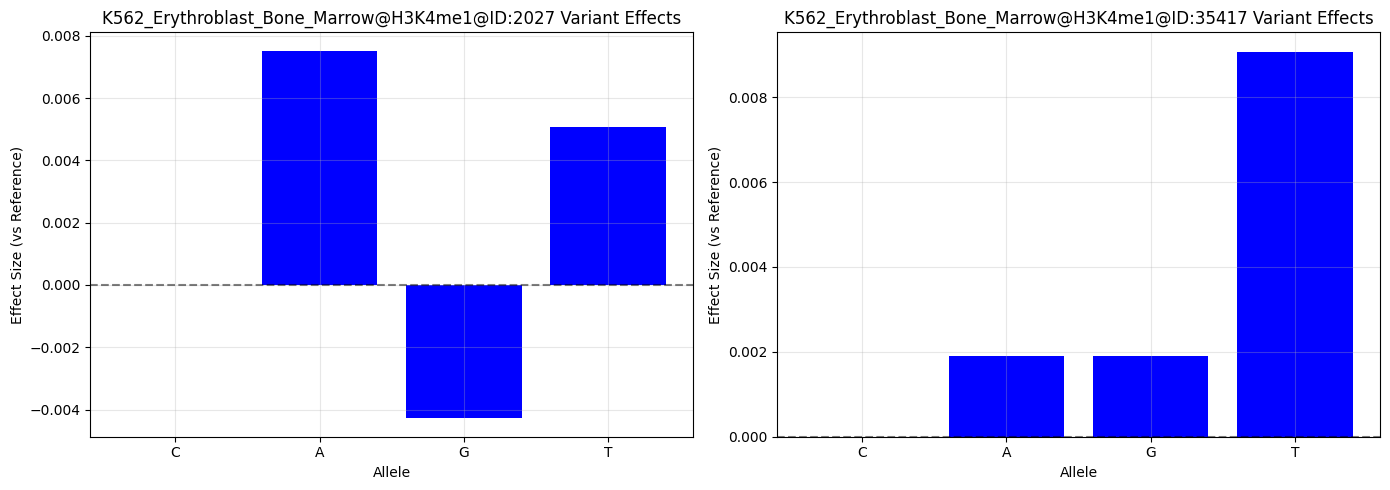


Saving variant tracks...


In [45]:
# Visualize variant effects as bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, track_id in enumerate(track_ids[:2]):
    track_data = variant_df[variant_df['Track'] == track_id]
    
    colors = ['red' if is_ref else 'blue' 
              for is_ref in track_data['Is_Reference']]
    
    axes[idx].bar(track_data['Allele'], track_data['Effect'], color=colors)
    axes[idx].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    track_id = track_id.split("#", maxsplit=1)[1]
    axes[idx].set_title(f"{track_id} Variant Effects")
    axes[idx].set_xlabel('Allele')
    axes[idx].set_ylabel('Effect Size (vs Reference)')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
# Display the figure
from IPython.display import display
display(fig)
plt.close()

# Save variant tracks
print("\nSaving variant tracks...")

# Save reference - predictions are already in the correct dictionary format
ref_preds = variant_results['predictions']['reference']
oracle.save_predictions_as_bedgraph(
    predictions=ref_preds,
    chrom='chrX',
    start=variant_pos,
    output_dir="bedgraph_outputs",
    prefix=f'd_variant_{ref_seq}'
)

# Save alternatives
for i, allele in enumerate(alt_alleles):
    allele_key = f'alt_{i+1}'
    if allele_key in variant_results['predictions']:
        # Predictions are already in the correct dictionary format
        variant_preds = variant_results['predictions'][allele_key]
        oracle.save_predictions_as_bedgraph(
            predictions=variant_preds,
            chrom='chrX',
            start=variant_pos,
            output_dir="bedgraph_outputs",
            prefix=f'd_variant_{allele}'
        )


## Example E: Direct Sequence Prediction

Demonstrate prediction on a synthetic sequence without genomic coordinates.

In [46]:
# Create a synthetic sequence with known regulatory elements
print("Creating synthetic sequence with regulatory elements...\n")

# Enformer requires exactly 393,216 bp
context_size = 393216

# Define regulatory elements
promoter_elements = {
    'TATA_box': 'TATAAA',
    'CAAT_box': 'CCAAT',
    'GC_box': 'GGGCGG',
    'GATA_motif': 'GATA',
    'E_box': 'CACGTG'
}

print("Regulatory elements used:")
for name, seq in promoter_elements.items():
    print(f"  {name}: {seq}")

Creating synthetic sequence with regulatory elements...

Regulatory elements used:
  TATA_box: TATAAA
  CAAT_box: CCAAT
  GC_box: GGGCGG
  GATA_motif: GATA
  E_box: CACGTG


In [47]:
# Build synthetic sequence
print("\nBuilding synthetic sequence...")
seq_parts = []
element_positions = []

for i in range(0, context_size, 1000):
    if i % 5000 == 0:
        # Add strong promoter every 5kb
        motifs = ''.join([
            promoter_elements['TATA_box'],
            'N' * 20,
            promoter_elements['CAAT_box'],
            'N' * 50,
            promoter_elements['GC_box']
        ])
        seq_parts.append(motifs)
        element_positions.append((i, 'promoter'))
    elif i % 3000 == 0:
        # Add enhancer elements
        enhancer = (promoter_elements['GATA_motif'] + 'NNNN') * 5
        seq_parts.append(enhancer)
        element_positions.append((i, 'enhancer'))
    else:
        # Random sequence
        seq_parts.append('ACGT' * 250)

# Combine and adjust to exact size
synthetic_seq = ''.join(seq_parts)[:context_size]

# Pad if needed
if len(synthetic_seq) < context_size:
    synthetic_seq += 'A' * (context_size - len(synthetic_seq))

print(f"\nFinal sequence length: {len(synthetic_seq):,} bp")
print(f"Number of promoter elements: {sum(1 for _, t in element_positions if t == 'promoter')}")
print(f"Number of enhancer elements: {sum(1 for _, t in element_positions if t == 'enhancer')}")


Building synthetic sequence...

Final sequence length: 393,216 bp
Number of promoter elements: 79
Number of enhancer elements: 105


In [48]:
# Make predictions on synthetic sequence
print("\nMaking predictions on synthetic sequence...\n")
synthetic_results = oracle.predict(
    synthetic_seq,
    track_ids  # Using specific track IDs
)

# Analyze predictions
print("Synthetic sequence predictions:")
for track_id, predictions in synthetic_results.items():
    print(f"\n{track_id}:")
    print(f"  Shape: {predictions.shape}")
    print(f"  Mean signal: {np.mean(predictions):.4f}")
    print(f"  Max signal: {np.max(predictions):.4f}")
    
    # Find top peaks
    top_bins = np.argsort(predictions)[-5:]
    print(f"  Top 5 peak bins: {top_bins}")
    print(f"  Peak values: {predictions[top_bins]}")


Making predictions on synthetic sequence...

Synthetic sequence predictions:

TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:2027:
  Shape: (96,)
  Mean signal: 0.0000
  Max signal: 0.0000
  Top 5 peak bins: [85 86 87 54 55]
  Peak values: [4.1431645e-06 4.1431645e-06 4.1431645e-06 4.1431645e-06 4.1431645e-06]

TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35417:
  Shape: (96,)
  Mean signal: 0.0000
  Max signal: 0.0000
  Top 5 peak bins: [85 86 87 54 55]
  Peak values: [1.1865102e-05 1.1865102e-05 1.1865102e-05 1.1865102e-05 1.1865102e-05]

CA#E1@Stem cell@Enhancer@5:
  Shape: (96,)
  Mean signal: 0.1996
  Max signal: 0.2692
  Top 5 peak bins: [42 48 29 11 23]
  Peak values: [0.23810598 0.25751728 0.25840086 0.2617901  0.2691764 ]

CA#E2@Multi-tissue@Enhancer@6:
  Shape: (96,)
  Mean signal: 0.2361
  Max signal: 0.3936
  Top 5 peak bins: [42 48 11 29 23]
  Peak values: [0.3608284  0.37829423 0.38282904 0.38356346 0.39361694]


Visualizing synthetic sequence predictions...


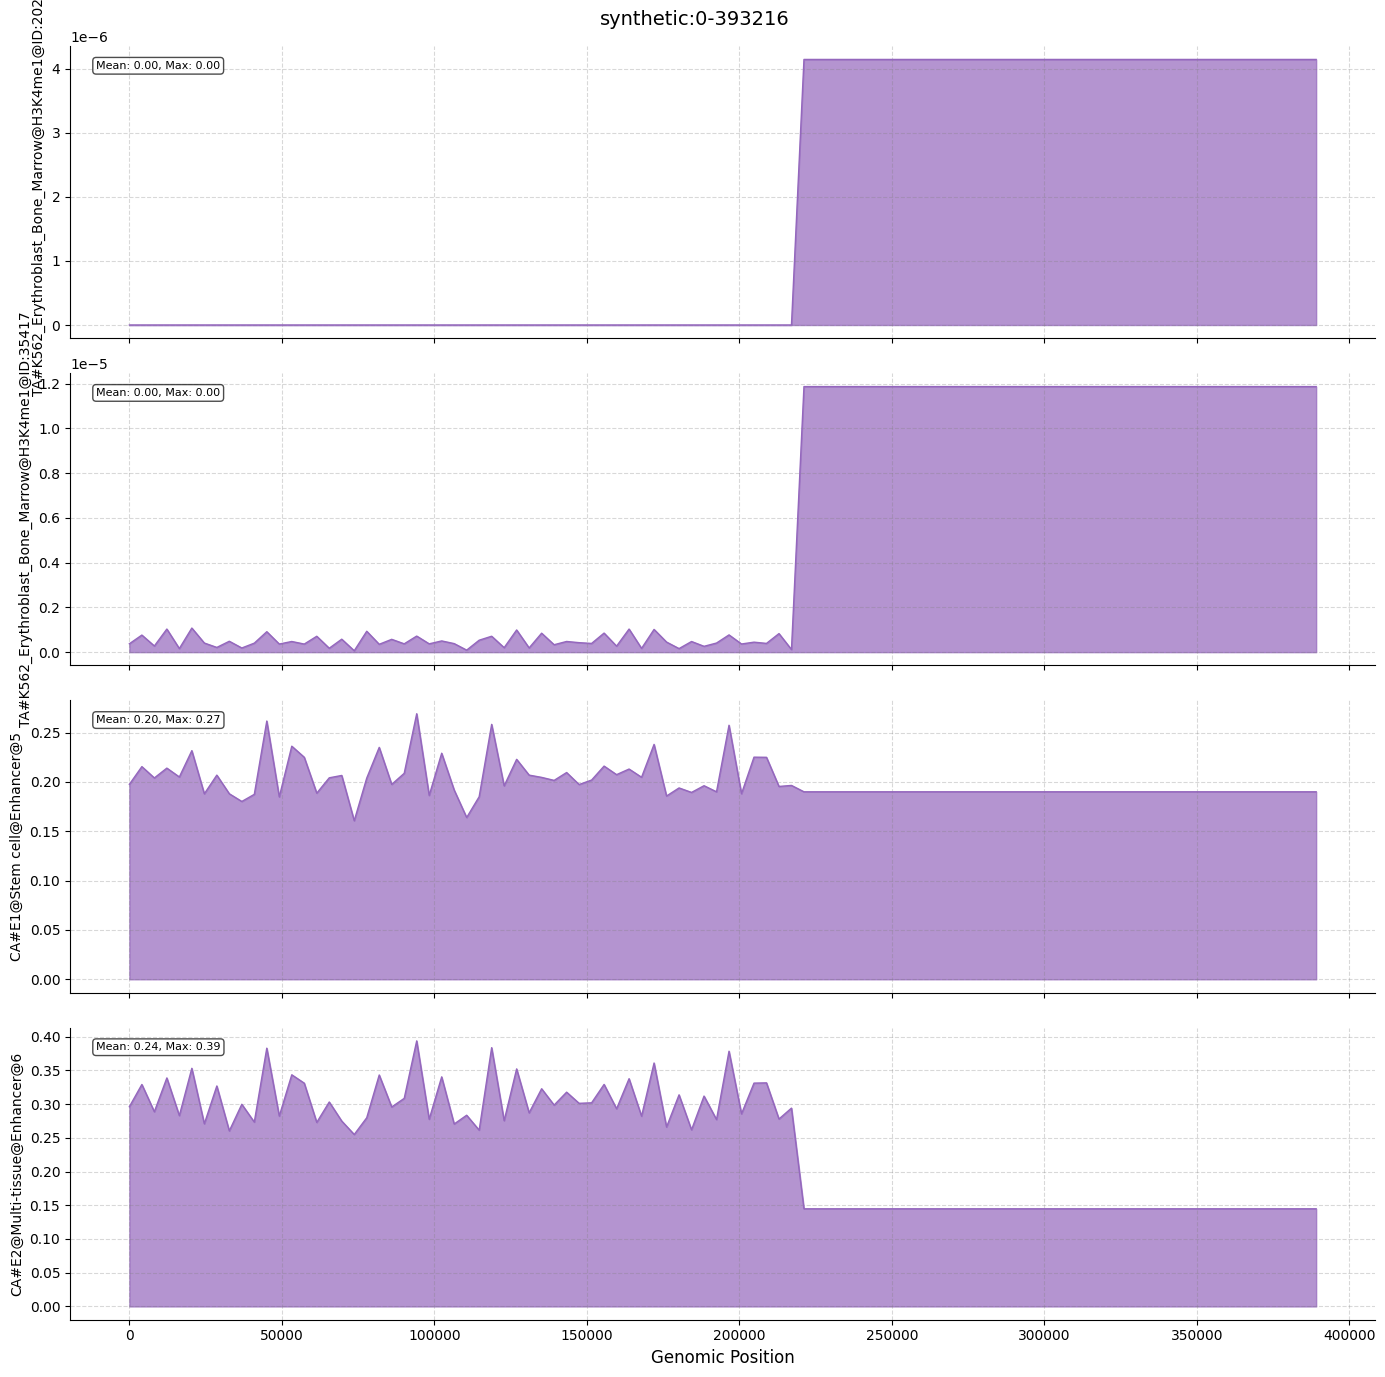


Saving synthetic sequence tracks...
Saved 4 files


In [49]:
# Visualize synthetic sequence predictions with improved plotting
print("Visualizing synthetic sequence predictions...")

visualize_chorus_predictions(
    predictions=synthetic_results,
    chrom='synthetic',
    start=0,
    track_ids=track_ids,
    output_file=None,
    bin_size=oracle.bin_size,
    style='modern',
    figsize=(14, 14)
)

# Save synthetic tracks
print("\nSaving synthetic sequence tracks...")
synthetic_files = oracle.save_predictions_as_bedgraph(
    predictions=synthetic_results,
    chrom='synthetic',
    start=0,
    output_dir="bedgraph_outputs",
    prefix='e_synthetic'
)
print(f"Saved {len(synthetic_files)} files")